# Python: Conditional Value at Risk of potential outcomes
In this example, we illustrate how the [DoubleML](https://docs.doubleml.org/stable/index.html) package can be used to estimate the conditional Value at Risk of potential outcomes. The estimation is based on [Kallus  et al. (2019)](https://arxiv.org/abs/1912.12945).

## Data
We define a data generating process to create synthetic data to compare the estimates to the true effect.

In [1]:
import numpy as np
import pandas as pd
import doubleml as dml
import multiprocessing

from lightgbm import LGBMClassifier, LGBMRegressor

The data is generated as a location-scale model with

$$Y_i = \text{loc}(D_i,X_i) + \text{scale}(D_i,X_i)\cdot\varepsilon_i,$$

where $X_i\sim\mathcal{U}[-1,1]^{p}$ and $\varepsilon_i \sim \mathcal{N}(0,1)$.
Further, the location and scale are determined according to the following functions

$$\begin{aligned}
\text{loc}(d,x) &:= 0.5d + 2dx_5 + 2\cdot 1\{x_2 > 0.1\} - 1.7\cdot 1\{x_1x_3 > 0\} - 3x_4 \\
\text{scale}(d,x) &:= \sqrt{0.5d + 0.3dx_1 + 2},
\end{aligned}$$

and the treatment takes the following form

$$D_i = 1_{\{(X_2 - X_4 + 1.5\cdot 1\{x_1 > 0\} + \epsilon_i > 0)\}}$$

with $\epsilon_i \sim \mathcal{N}(0,1)$.

In [2]:
def f_loc(D, X):
  loc = 0.5*D + 2*D*X[:,4] + 2.0*(X[:,1] > 0.1) - 1.7*(X[:,0] * X[:,2] > 0) - 3*X[:,3]
  return loc

def f_scale(D, X):
  scale = np.sqrt(0.5*D + 0.3*D*X[:,1] + 2)
  return scale

def dgp(n=200, p=5):
    X = np.random.uniform(-1,1,size=[n,p])
    D = ((X[:,1 ] - X[:,3] + 1.5*(X[:,0] > 0) + np.random.normal(size=n)) > 0)*1.0
    epsilon = np.random.normal(size=n)

    Y = f_loc(D, X) + f_scale(D, X)*epsilon

    return Y, X, D, epsilon

We can calculate the true conditional value at risk through simulations. Here, we will just approximate the true conditional value at risk for the potential outcomes for a range of quantiles.

In [3]:
tau_vec = np.arange(0.1,0.95,0.05)
p = 5
n_true = int(10e+6)

_, X_true, _, epsilon_true = dgp(n=n_true, p = p)
D1 = np.ones(n_true)
D0 = np.zeros(n_true)

Y1 = f_loc(D1, X_true) + f_scale(D1, X_true)*epsilon_true
Y0 = f_loc(D0, X_true) + f_scale(D0, X_true)*epsilon_true

Y1_quant = np.quantile(Y1, q=tau_vec)
Y0_quant = np.quantile(Y0, q=tau_vec)

Y1_cvar = [Y1[Y1 >= quant].mean() for quant in Y1_quant]
Y0_cvar = [Y0[Y0 >= quant].mean() for quant in Y0_quant]

print(f'Conditional Value at Risk Y(0): {Y0_cvar}')
print(f'Conditional Value at Risk Y(1): {Y1_cvar}')

Conditional Value at Risk Y(0): [0.5468302096489664, 0.7562341689454838, 0.9572177197180632, 1.153794131520518, 1.3485773282548525, 1.5436029184344204, 1.7406615934197434, 1.941599873075862, 2.1483082274558445, 2.3630484107205936, 2.5885146547401563, 2.828181363298142, 3.0867301003356706, 3.3714432799341103, 3.6936238456223904, 4.073784286095536, 4.555207325379444]
Conditional Value at Risk Y(1): [1.1116878775543169, 1.3462676508520117, 1.571096957998933, 1.790856303178652, 2.008723876209517, 2.2270593382024044, 2.447983612884303, 2.673570533528913, 2.9061213844365232, 3.148257435404214, 3.40321783079913, 3.6750860218310804, 3.969754340741259, 4.295740189189567, 4.666919976960692, 5.108119056455548, 5.672289736890276]


Let us generate $n=5000$ observations and convert them to a [DoubleMLData](https://docs.doubleml.org/stable/api/generated/doubleml.DoubleMLData.html) object.

In [4]:
n = 5000
np.random.seed(42)
Y, X, D, _ = dgp(n=n,p=p)
obj_dml_data = dml.DoubleMLData.from_arrays(X, Y, D)

## Conditional Value at Risk (CVaR)
Next, we can initialize our two machine learning algorithms to train the different nuisance elements (remark that in contrast to potential quantile estimation `ml_g` is a regressor). Then we can initialize the `DoubleMLCVAR` objects and call `fit()` to estimate the relevant parameters. To obtain confidence intervals, we can use the `confint()` method.

In [5]:
ml_g = LGBMRegressor(n_estimators=300, learning_rate=0.05, num_leaves=10)
ml_m = LGBMClassifier(n_estimators=300, learning_rate=0.05, num_leaves=10)

CVAR_0 = np.full((len(tau_vec)), np.nan)
CVAR_1 = np.full((len(tau_vec)), np.nan)

ci_CVAR_0 = np.full((len(tau_vec),2), np.nan)
ci_CVAR_1 = np.full((len(tau_vec),2), np.nan)

for idx_tau, tau in enumerate(tau_vec):
    print(f'Quantile: {tau}')
    dml_CVAR_0 = dml.DoubleMLCVAR(obj_dml_data,
                                ml_g, ml_m,
                                quantile=tau,
                                treatment=0,
                                n_folds=5)
    dml_CVAR_1 = dml.DoubleMLCVAR(obj_dml_data,
                                ml_g, ml_m,
                                quantile=tau,
                                treatment=1,
                                n_folds=5)

    dml_CVAR_0.fit()
    dml_CVAR_1.fit()

    ci_CVAR_0[idx_tau, :] = dml_CVAR_0.confint(level=0.95).to_numpy()
    ci_CVAR_1[idx_tau, :] = dml_CVAR_1.confint(level=0.95).to_numpy()

    CVAR_0[idx_tau] = dml_CVAR_0.coef
    CVAR_1[idx_tau] = dml_CVAR_1.coef

Quantile: 0.1


Quantile: 0.15000000000000002


Quantile: 0.20000000000000004


Quantile: 0.25000000000000006


Quantile: 0.30000000000000004


Quantile: 0.3500000000000001


Quantile: 0.40000000000000013


Quantile: 0.45000000000000007


Quantile: 0.5000000000000001


Quantile: 0.5500000000000002


Quantile: 0.6000000000000002


Quantile: 0.6500000000000001


Quantile: 0.7000000000000002


Quantile: 0.7500000000000002


Quantile: 0.8000000000000002


Quantile: 0.8500000000000002


Quantile: 0.9000000000000002


Finally, let us take a look at the estimated values.

In [6]:
data = {"Quantile": tau_vec, "CVaR Y(0)": Y0_cvar, "CVaR Y(1)": Y1_cvar,
        "DML CVaR Y(0)": CVAR_0, "DML CVaR Y(1)": CVAR_1,
        "DML CVaR Y(0) lower": ci_CVAR_0[:, 0], "DML CVaR Y(0) upper": ci_CVAR_0[:, 1],
        "DML CVaR Y(1) lower": ci_CVAR_1[:, 0], "DML CVaR Y(1) upper": ci_CVAR_1[:, 1]}
df = pd.DataFrame(data)
print(df)

    Quantile  CVaR Y(0)  CVaR Y(1)  DML CVaR Y(0)  DML CVaR Y(1)   
0       0.10   0.546830   1.111688       0.360683       1.057962  \
1       0.15   0.756234   1.346268       0.590911       1.273356   
2       0.20   0.957218   1.571097       0.829543       1.489699   
3       0.25   1.153794   1.790856       1.015038       1.697000   
4       0.30   1.348577   2.008724       1.203284       1.925736   
5       0.35   1.543603   2.227059       1.502494       2.144084   
6       0.40   1.740662   2.447984       1.678826       2.338775   
7       0.45   1.941600   2.673571       1.822482       2.559144   
8       0.50   2.148308   2.906121       2.153119       2.824701   
9       0.55   2.363048   3.148257       2.156969       3.041831   
10      0.60   2.588515   3.403218       2.495657       3.298120   
11      0.65   2.828181   3.675086       2.653846       3.582761   
12      0.70   3.086730   3.969754       2.847948       3.842405   
13      0.75   3.371443   4.295740       3.07634

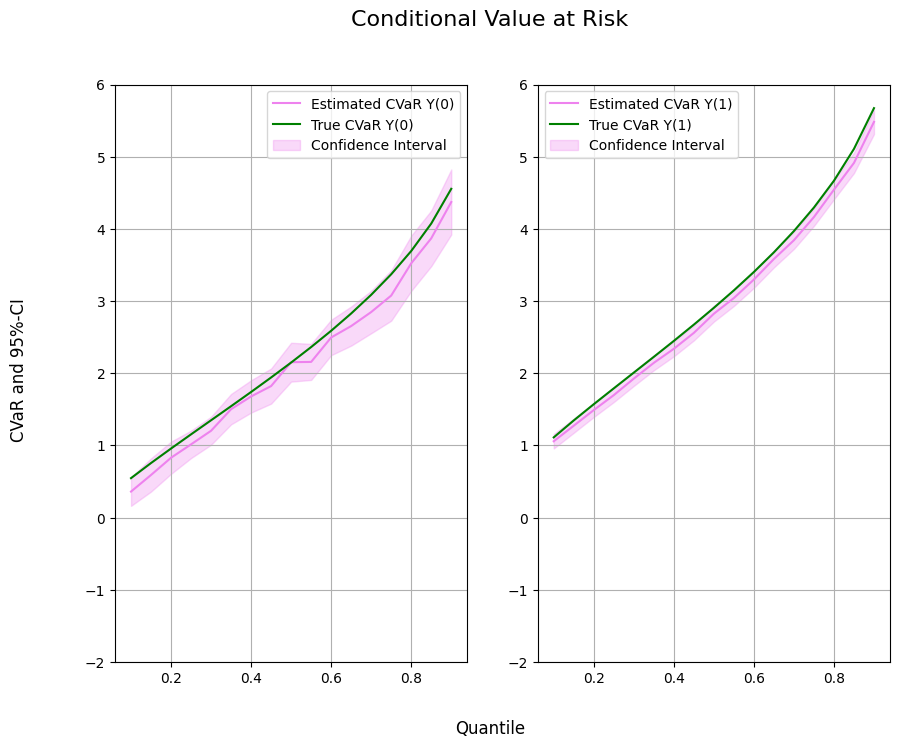

In [7]:
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = 10., 7.5
fig, (ax1, ax2) = plt.subplots(1 ,2)
ax1.grid(); ax2.grid()

ax1.plot(df['Quantile'],df['DML CVaR Y(0)'], color='violet', label='Estimated CVaR Y(0)')
ax1.plot(df['Quantile'],df['CVaR Y(0)'], color='green', label='True CVaR Y(0)')
ax1.fill_between(df['Quantile'], df['DML CVaR Y(0) lower'], df['DML CVaR Y(0) upper'], color='violet', alpha=.3, label='Confidence Interval')
ax1.legend()
ax1.set_ylim(-2, 6)

ax2.plot(df['Quantile'],df['DML CVaR Y(1)'], color='violet', label='Estimated CVaR Y(1)')
ax2.plot(df['Quantile'],df['CVaR Y(1)'], color='green', label='True CVaR Y(1)')
ax2.fill_between(df['Quantile'], df['DML CVaR Y(1) lower'], df['DML CVaR Y(1) upper'], color='violet', alpha=.3, label='Confidence Interval')
ax2.legend()
ax2.set_ylim(-2, 6)

fig.suptitle('Conditional Value at Risk', fontsize=16)
fig.supxlabel('Quantile')
_ = fig.supylabel('CVaR and 95%-CI')

## CVaR Treatment Effects
In most cases, we want to evaluate the treatment effect on the CVaR as the difference between potential CVaRs.
To estimate the treatment effect, we can use the `DoubleMLQTE` object and specify `CVaR` as the score. 

As for quantile treatment effects, different quantiles can be estimated in parallel with `n_jobs_models`.

In [8]:
n_cores = multiprocessing.cpu_count()
cores_used = np.min([5, n_cores - 1])
print(f"Number of Cores used: {cores_used}")

dml_CVAR = dml.DoubleMLQTE(obj_dml_data,
                           ml_g,
                           ml_m,
                           score='CVaR',
                           quantiles=tau_vec,
                           n_folds=5)
dml_CVAR.fit(n_jobs_models=cores_used)
print(dml_CVAR)

Number of Cores used: 1


================== DoubleMLQTE Object ==================

------------------ Fit summary       ------------------
          coef   std err         t         P>|t|     2.5 %    97.5 %
0.10  0.627564  0.103806  6.045553  1.488982e-09  0.424108  0.831019
0.15  0.677980  0.102616  6.606954  3.923074e-11  0.476856  0.879103
0.20  0.706645  0.100356  7.041387  1.903351e-12  0.509951  0.903339
0.25  0.716793  0.102775  6.974414  3.071488e-12  0.515358  0.918227
0.30  0.716762  0.107073  6.694154  2.169230e-11  0.506903  0.926621
0.35  0.740869  0.112216  6.602168  4.051867e-11  0.520930  0.960808
0.40  0.756969  0.114647  6.602628  4.039310e-11  0.532266  0.981672
0.45  0.751710  0.117710  6.386102  1.701672e-10  0.521002  0.982417
0.50  0.779682  0.122408  6.369556  1.895768e-10  0.539767  1.019596
0.55  0.786744  0.130370  6.034690  1.592681e-09  0.531223  1.042265
0.60  0.814351  0.138378  5.884996  3.980643e-09  0.543136  1.085566
0.65  0.848868  0.144800  5.862359  4.563374e-09  0.565066

As for standard `DoubleMLCVAR` objects, we can construct valid confidencebands with the `confint()` method. Additionally, it might be helpful to construct uniformly valid confidence regions via boostrap.

In [9]:
ci_CVAR = dml_CVAR.confint(level=0.95, joint=False)

dml_CVAR.bootstrap(n_rep_boot=2000)
ci_joint_CVAR = dml_CVAR.confint(level=0.95, joint=True)
ci_joint_CVAR

,2.5 %,97.5 %
0.10,0.367571,0.887556
0.15,0.420967,0.934992
0.20,0.455293,0.957996
0.25,0.459383,0.974202
0.30,0.448587,0.984937
0.35,0.459812,1.021926
0.40,0.469825,1.044113
0.45,0.456892,1.046527
0.50,0.473099,1.086264
0.55,0.460218,1.113270


Finally, we can compare the predicted treatment effect with the true treatment effect on the CVaR.

In [10]:
CVAR = np.array(Y1_cvar) - np.array(Y0_cvar)
data = {"Quantile": tau_vec, "CVaR": CVAR, "DML CVaR": dml_CVAR.coef,
        "DML CVaR pointwise lower": ci_CVAR['2.5 %'], "DML CVaR pointwise upper": ci_CVAR['97.5 %'],
        "DML CVaR joint lower": ci_joint_CVAR['2.5 %'], "DML CVaR joint upper": ci_joint_CVAR['97.5 %']}
df = pd.DataFrame(data)
print(df)

      Quantile      CVaR  DML CVaR  DML CVaR pointwise lower   
0.10      0.10  0.564858  0.627564                  0.424108  \
0.15      0.15  0.590033  0.677980                  0.476856   
0.20      0.20  0.613879  0.706645                  0.509951   
0.25      0.25  0.637062  0.716793                  0.515358   
0.30      0.30  0.660147  0.716762                  0.506903   
0.35      0.35  0.683456  0.740869                  0.520930   
0.40      0.40  0.707322  0.756969                  0.532266   
0.45      0.45  0.731971  0.751710                  0.521002   
0.50      0.50  0.757813  0.779682                  0.539767   
0.55      0.55  0.785209  0.786744                  0.531223   
0.60      0.60  0.814703  0.814351                  0.543136   
0.65      0.65  0.846905  0.848868                  0.565066   
0.70      0.70  0.883024  0.946968                  0.643512   
0.75      0.75  0.924297  0.997621                  0.674609   
0.80      0.80  0.973296  1.073520      

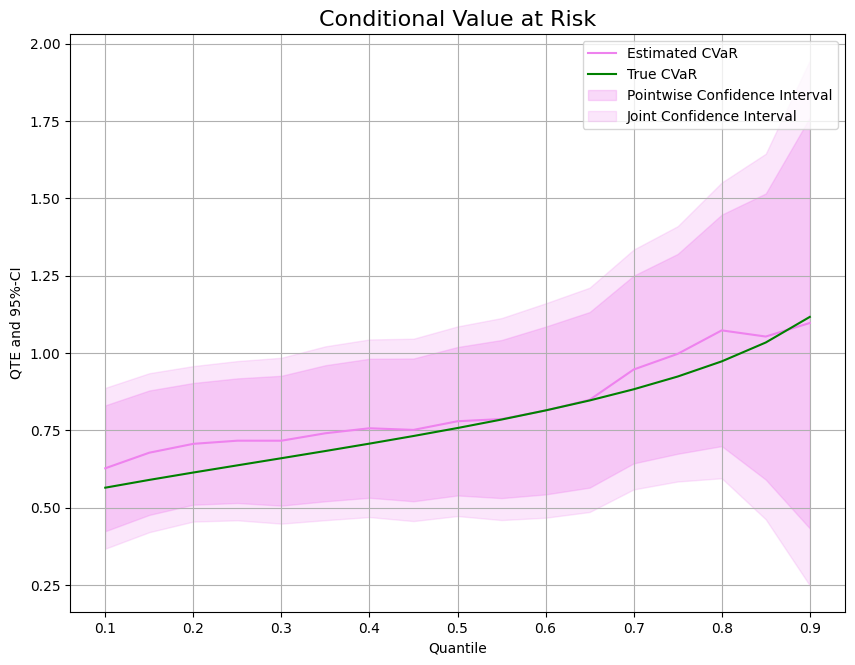

In [11]:
plt.rcParams['figure.figsize'] = 10., 7.5
fig, ax = plt.subplots()
ax.grid()

ax.plot(df['Quantile'],df['DML CVaR'], color='violet', label='Estimated CVaR')
ax.plot(df['Quantile'],df['CVaR'], color='green', label='True CVaR')
ax.fill_between(df['Quantile'], df['DML CVaR pointwise lower'], df['DML CVaR pointwise upper'], color='violet', alpha=.3, label='Pointwise Confidence Interval')
ax.fill_between(df['Quantile'], df['DML CVaR joint lower'], df['DML CVaR joint upper'], color='violet', alpha=.2, label='Joint Confidence Interval')

plt.legend()
plt.title('Conditional Value at Risk', fontsize=16)
plt.xlabel('Quantile')
_ = plt.ylabel('QTE and 95%-CI')